<a href="https://colab.research.google.com/github/Chebem/Audio_Processing/blob/main/P06_E2E_Voice_Recogintion_Model_Practice_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

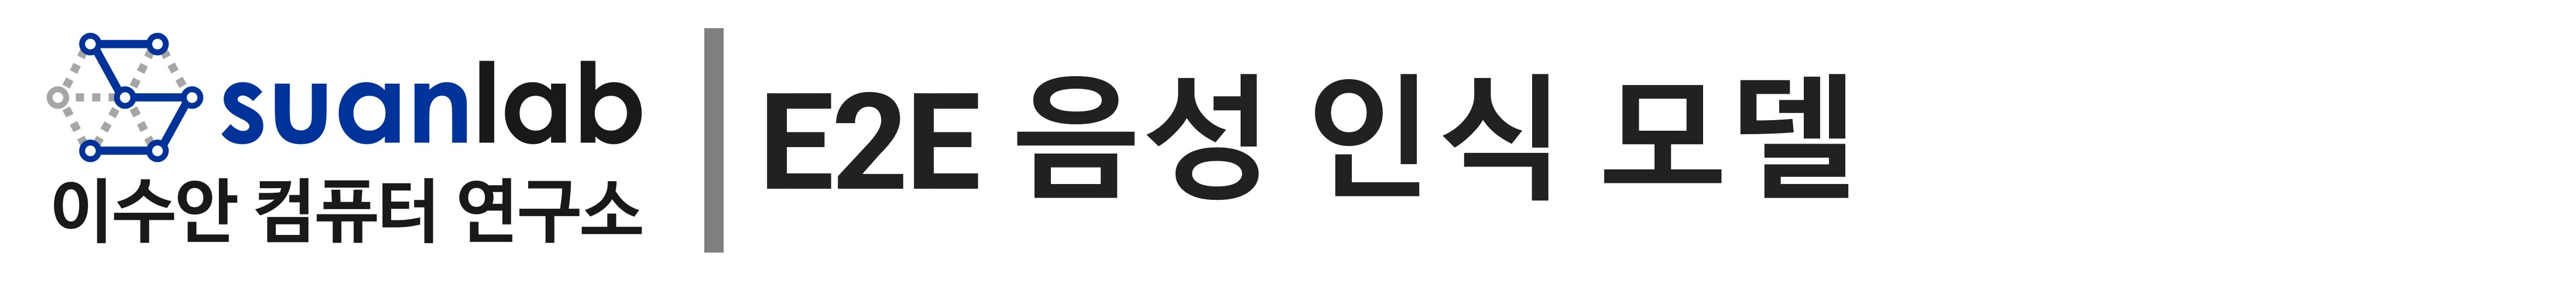

# Listen Attend Spell (LAS), 2015

- Seq2Seq 기반으로 음성 인식에 Attention 메커니즘을 도입한 초기 End-to-End 모델
- **Listener (Encoder)**: 음성 특징(예: Mel-Spectrogram)을 입력받아 고수준의 표현(representation)으로 변환하며, 주로 피라미드 형태의 순환 신경망(Pyramidal RNN, 보통 LSTM)을 사용
- **Attention Mechanism**: Listener의 출력과 Speller의 현재 상태를 기반으로, 어떤 시점의 음성 특징에 집중해야 할지 결정
- **Speller (Decoder)**: Attention으로부터 얻은 문맥 벡터(context vector)와 이전 단계에서 예측한 문자를 바탕으로 다음 문자를 예측

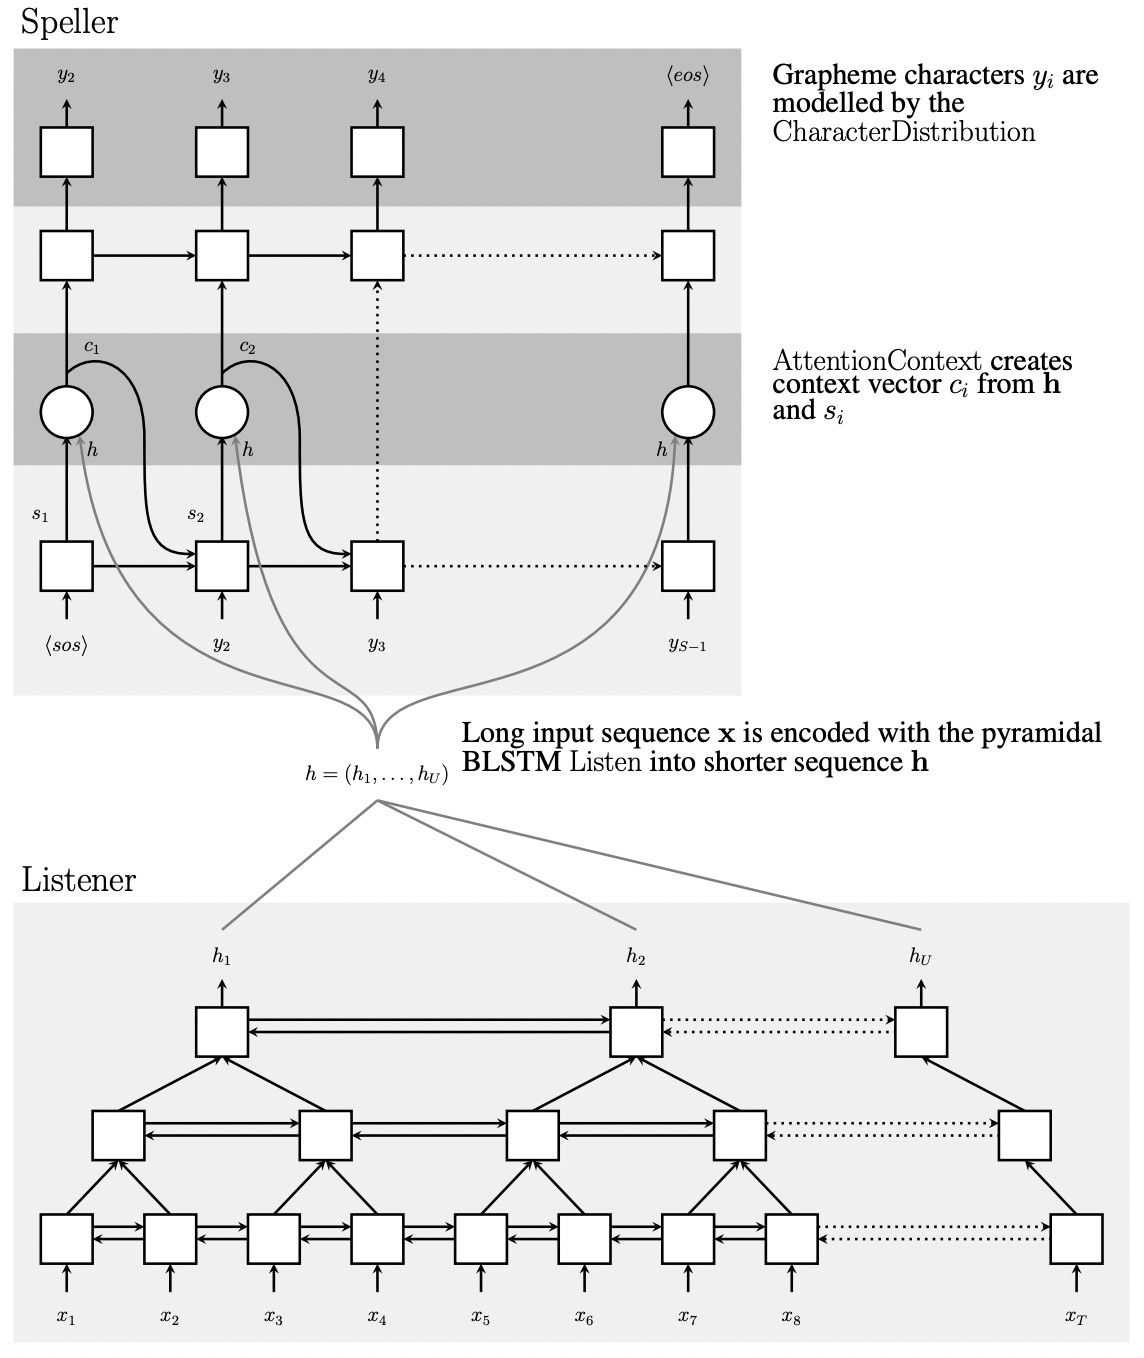

`torch`와 `torchaudio` 설치

In [2]:
!pip install torch
!pip install torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np

In [4]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [01:37<00:00, 65.4MB/s]
100%|██████████| 331M/331M [00:05<00:00, 68.4MB/s]


In [5]:
test_dataset[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [6]:
import numpy as np
import torch
import torch.nn as nn

#Since torchaudio is used in the code, add the import statement (necessary when actually running)".

import torchaudio
import torchaudio.transforms

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio

# Average Word Error Rate
def avg_wer(wer_scores, combined_ref_len):
    """
    Calculate the Average Word Error Rate (WER) across multiple sentences.
    Args:
        wer_scores (list): List of edit distances per sentence.
        combined_ref_len (int): Total number of words across all reference sentences.
    Returns:
        float: Average WER (total word errors / total reference words).
    """
    return float(sum(wer_scores)) / float(combined_ref_len)

# Levenshtein Distance Calculation
def _levenshtein_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m
    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    distance = np.zeros((2, n + 1), dtype=np.int32)
    for j in range(n + 1):
        distance[0][j] = j

    for i in range(1, m + 1):
        prev, curr = (i - 1) % 2, i % 2
        distance[curr][0] = i
        for j in range(1, n + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            distance[curr][j] = min(
                distance[prev][j - 1] + cost,  # substitution
                distance[curr][j - 1] + 1,     # insertion
                distance[prev][j] + 1          # deletion
            )
    return distance[m % 2][n]

# Word Error Calculation
def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case:
        reference = reference.lower()
        hypothesis = hypothesis.lower()
    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)
    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)

# Character Error Calculation
def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case:
        reference = reference.lower()
        hypothesis = hypothesis.lower()
    join_char = '' if remove_space else ' '
    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))
    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)

# Word Error Rate
def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case, delimiter)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")
    return float(edit_distance) / ref_len

# Character Error Rate
def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case, remove_space)
    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")
    return float(edit_distance) / ref_len

# Text Transform Utility
class TextTransform:
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[self.char_map['<SPACE>']] = ' '

    def text_to_int(self, text):
        int_sequence = []
        for c in text:
            ch = self.char_map['<SPACE>'] if c == ' ' else self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        string = []
        for i in labels:
          label_val = i.item() if hasattr(i, 'item') else i
          if label_val == 28:
            continue  # Skip CTC blank token
          string.append(self.index_map[label_val])
        return ''.join(string)

# Audio Data Preprocessing
text_transform = TextTransform()
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000,n_fft=1024, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)
valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)

def data_processing(data, data_type="train"):
    spectrograms, labels, input_lengths, label_lengths = [], [], [], []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    return spectrograms, labels, input_lengths, label_lengths

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [8]:
import torch
import torch.nn as nn
import math


class EncoderRNN(nn.Module):
    """
    Encoder class that transforms input speech features (e.g., spectrograms) into high-level representations.
    Uses CNN layers to extract local features and RNN layers to model temporal dependencies.
    """

    def __init__(self, input_size, hidden_size, n_layers=1,
                 input_dropout_p=0, dropout_p=0,
                 bidirectional=False, rnn_cell='gru', variable_lengths=False):
        """
        Initialize EncoderRNN.
        Args:
            input_size (int): Number of input frequency bins (D in spectrogram).
            hidden_size (int): Hidden size of the RNN.
            n_layers (int, optional): Number of RNN layers.
            input_dropout_p (float, optional): Dropout on input to RNN (not used directly in this code).
            dropout_p (float, optional): Dropout between RNN layers (applied if n_layers > 1).
            bidirectional (bool, optional): Whether to use bidirectional RNN.
            rnn_cell (str, optional): Type of RNN cell ('lstm' or 'gru').
            variable_lengths (bool, optional): Whether to handle variable-length sequences.
        """
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.bidirectional = bidirectional
        self.variable_lengths = variable_lengths

        # Select RNN cell type
        if rnn_cell.lower() == 'lstm':
            self.rnn_cell = nn.LSTM
        elif rnn_cell.lower() == 'gru':
            self.rnn_cell = nn.GRU
        else:
            raise ValueError(f"Unsupported RNN Cell: {rnn_cell}")

        # Define CNN layers
        self.outputs_channel = 32  # Number of output channels in CNN
        self.conv = nn.Sequential(
            # First Conv2D: input (B, 1, D, T) -> output (B, 32, D', T')
            nn.Conv2d(1, self.outputs_channel, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(self.outputs_channel),
            nn.Hardtanh(0, 20, inplace=True),
            # Second Conv2D: output (B, 32, D'', T'')
            nn.Conv2d(self.outputs_channel, self.outputs_channel, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(self.outputs_channel),
            nn.Hardtanh(0, 20, inplace=True)
        )

        # Calculate output frequency dimension after CNN to determine RNN input size
        # Output size = floor((Input + 2*Padding - Kernel) / Stride + 1)
        rnn_input_dims = int(math.floor((input_size + 2 * 20 - 41) / 2 + 1))  # after first conv
        rnn_input_dims = int(math.floor((rnn_input_dims + 2 * 10 - 21) / 2 + 1))  # after second conv
        rnn_input_dims *= self.outputs_channel  # Multiply by number of channels

        # Define RNN layer
        self.rnn = self.rnn_cell(
            input_size=rnn_input_dims,       # Input dimension from CNN output
            hidden_size=self.hidden_size,    # Hidden size of RNN
            num_layers=self.n_layers,        # Number of layers
            dropout=self.dropout_p if self.n_layers > 1 else 0,  # Dropout only if multiple layers
            bidirectional=self.bidirectional,
            batch_first=False                # Input shape should be (T, B, D) for packing
        )

    def forward(self, input_var, input_lengths=None):
        """
        Forward pass of the encoder.
        Args:
            input_var (Tensor): Input spectrograms, shape (B, 1, D, T)
            input_lengths (Tensor, optional): Original time lengths of each input, shape (B,)
        Returns:
            Tuple of:
                - output: Tensor of shape (B, T_cnn, D_rnn)
                - h_state: Final hidden state of RNN
        """
        # Calculate output time lengths after CNN
        output_lengths = self.get_seq_lens(input_lengths)

        # Apply CNN: input shape (B, 1, D, T) → output shape (B, C, D', T')
        x = self.conv(input_var)

        # Reshape for RNN input: (B, C, D', T') → (T', B, C * D')
        B, C, D, T = x.size()
        x = x.view(B, C * D, T).transpose(1, 2).transpose(0, 1).contiguous()

        # Pack padded sequence for efficient RNN processing
        x_packed = nn.utils.rnn.pack_padded_sequence(x, output_lengths.cpu(), enforce_sorted=False)

        # Pass through RNN
        x_packed, h_state = self.rnn(x_packed)

        # Unpack sequence
        x, _ = nn.utils.rnn.pad_packed_sequence(x_packed)

        # Transpose to (B, T, D)
        x = x.transpose(0, 1)
        return x, h_state

    def get_seq_lens(self, input_lengths):
        """
        Calculates the time dimension size after CNN layers.
        Args:
            input_lengths (Tensor): Original time lengths before CNN, shape (B,)
        Returns:
            Tensor: Time lengths after CNN, shape (B,)
        """
        seq_len = input_lengths.float()
        for m in self.conv.modules():
            if isinstance(m, nn.Conv2d):
                # Output length formula: floor((L + 2P - K - 1) / S + 1)
                seq_len = torch.floor(
                    (seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) / m.stride[1] + 1
                )
        return seq_len.int()

In [9]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    """
    Location-Aware Attention mechanism.
    Calculates a context vector based on:
    - the current decoder hidden state (queries),
    - the encoder outputs (values),
    - the previous time step's attention weights (last_attn).
    This mechanism uses a convolution over previous attention weights to incorporate positional information.
    """
    def __init__(self, dec_dim, enc_dim, conv_dim, attn_dim):
        """
        Initialize the attention layer.
        Args:
            dec_dim (int): Decoder hidden state dimension (query Q).
            enc_dim (int): Encoder output dimension (key K and value V).
            conv_dim (int): Output dimension after convolution on previous attention weights.
                            (In this implementation, attn_dim is used instead.)
            attn_dim (int): Internal attention feature dimension for projections.
        """
        super(Attention, self).__init__()
        self.dec_dim = dec_dim
        self.enc_dim = enc_dim
        self.conv_dim = conv_dim
        self.attn_dim = attn_dim

        # Convolution over previous attention weights:
        # Input: (B, 1, T_enc), Output: (B, attn_dim, T_enc)
        self.conv = nn.Conv1d(in_channels=1, out_channels=self.attn_dim, kernel_size=3, padding=1)

        # Linear projection of decoder hidden state (query)
        self.W = nn.Linear(self.dec_dim, self.attn_dim, bias=False)

        # Linear projection of encoder outputs (keys/values)
        self.V = nn.Linear(self.enc_dim, self.attn_dim, bias=False)

        # Final scoring layer to compute attention energy (scalar per time step)
        self.fc = nn.Linear(self.attn_dim, 1, bias=True)

        # Learnable bias vector added before tanh
        self.b = nn.Parameter(torch.rand(self.attn_dim))

        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, queries, values, last_attn):
        """
        Compute the attention context vector and weights.
        Args:
            queries (Tensor): Current decoder hidden state, shape (B, 1, dec_dim)
            values (Tensor): Encoder outputs, shape (B, T_enc, enc_dim)
            last_attn (Tensor): Previous attention weights, shape (B, T_enc)
        Returns:
            context (Tensor): Context vector, shape (B, 1, enc_dim)
            attn_weight (Tensor): Attention weights, shape (B, T_enc)
        """
        batch_size = queries.size(0)

        # 1. Convolve previous attention weights for positional features
        # Shape: (B, T_enc) -> (B, 1, T_enc) -> Conv1d -> (B, attn_dim, T_enc) -> Transpose -> (B, T_enc, attn_dim)
        conv_attn = torch.transpose(self.conv(last_attn.unsqueeze(dim=1)), 1, 2)

        # 2. Project queries, keys, and convolved attention to attn_dim
        # Shapes:
        # - self.W(queries): (B, 1, attn_dim)
        # - self.V(values):  (B, T_enc, attn_dim)
        # - conv_attn:        (B, T_enc, attn_dim)
        # - self.b:           (attn_dim), broadcasted to (B, T_enc, attn_dim)

        energy = self.fc(self.tanh(
            self.W(queries) + self.V(values) + conv_attn + self.b
        )).squeeze(dim=-1)  # Final shape: (B, T_enc)

        # 3. Compute attention weights via softmax
        attn_weight = self.softmax(energy)  # Shape: (B, T_enc)

        # 4. Compute context vector as weighted sum of encoder outputs
        # Shapes:
        # - attn_weight: (B, T_enc) -> (B, 1, T_enc)
        # - values:      (B, T_enc, enc_dim)
        # - context:     (B, 1, enc_dim)
        context = torch.bmm(attn_weight.unsqueeze(1), values)

        return context, attn_weight

# DeepSpeech2, 2016

Baidu에서 개발한 음성 인식 모델로, 음향 및 언어 모델을 통합한 대규모 RNN 구조를 사용

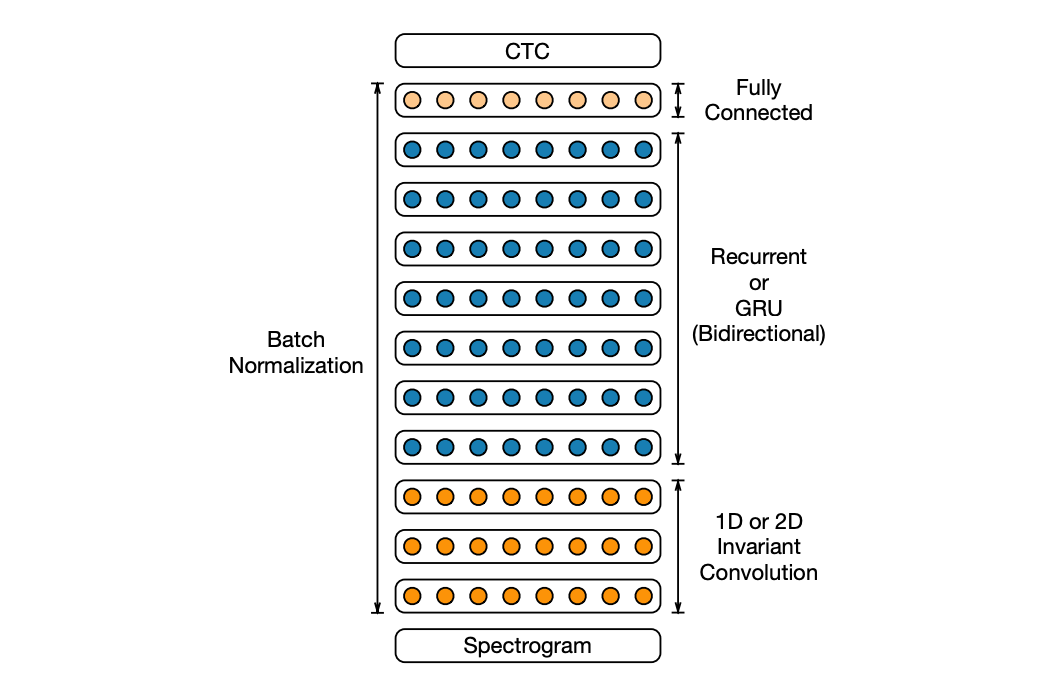

In [10]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    """
    Greedy decoding function for CTC-based models.
    Converts output probabilities to character sequences by selecting the most likely character at each timestep.

    Args:
        output (torch.Tensor): Model output tensor of shape (batch, time, num_classes).
        labels (torch.Tensor): Ground-truth label tensor of shape (batch, max_label_len).
        label_lengths (torch.Tensor or list): Actual lengths of each label sequence.
        blank_label (int): Index used for the CTC blank token (default: 28).
        collapse_repeated (bool): Whether to collapse repeated characters in output (CTC standard).

    Returns:
        tuple: (decoded_predictions, ground_truth_labels)
            - decoded_predictions: list of decoded strings from model output.
            - ground_truth_labels: list of actual target strings.
    """
    # Take argmax over the class dimension to get most likely class at each time step
    # output shape: (B, T, C) → arg_maxes shape: (B, T)
    arg_maxes = torch.argmax(output, dim=2)

    decodes = []  # List to store decoded predictions
    targets = []  # List to store true target strings

    # Process each sample in the batch
    for i, args in enumerate(arg_maxes):
        decode = []  # Stores decoded character indices for this sample

        # Convert the label sequence for this sample to a string
        # - labels[i] is the full (possibly padded) label tensor
        # - label_lengths[i] gives the true length
        target_indices = [idx for idx in labels[i][:label_lengths[i]].tolist() if idx != blank_label]
        targets.append(text_transform.int_to_text(target_indices))


        # Iterate through each timestep prediction
        for j, index_tensor in enumerate(args):
            index = index_tensor.item()  # Convert tensor to int

            # Skip blank label
            if index != blank_label:
                # If collapsing repeated characters: skip if current == previous
                if collapse_repeated and j != 0 and index == args[j - 1].item():
                    continue  # Skip if repeated character and collapsing is enabled
                decode.append(index)  # Append the valid index

        # Convert decoded indices to string and add to results
        decodes.append(text_transform.int_to_text(decode))

    return decodes, targets

In [11]:
 #CNNLayerNorm — LayerNorm adapted for CNN
class CNNLayerNorm(nn.Module):
    """
    Applies Layer Normalization over the channel dimension of CNN outputs.
    Since CNN outputs are usually in shape (N, C, H, W) or (N, C, L),
    this module transposes dimensions so normalization can be applied to the feature axis.
    """
    def __init__(self, n_feats):
        """
        Args:
            n_feats (int): Number of features to normalize over (typically the feature dimension).
        """
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        """
        Args:
            x (Tensor): Shape (batch, channel, feature, time)
        Returns:
            Tensor: Normalized tensor with the same shape
        """
        x = x.transpose(2, 3).contiguous()
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()



In [12]:
# ResidualCNN — Residual CNN Block with GELU and LayerNorm

class ResidualCNN(nn.Module):
    """
    A residual convolutional block with two Conv2d layers, GELU activation,
    dropout, and layer normalization.
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        """
        Args:
            x (Tensor): Shape (batch, channel, feature, time)
        Returns:
            Tensor: Output with the same shape (if stride=1)
        """
        residual = x
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)

        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)

        x += residual
        return x


In [13]:
# BidirectionalGRU — BiGRU Block with GELU and LayerNorm

class BidirectionalGRU(nn.Module):
    """
    A wrapper for a bidirectional GRU with layer normalization, GELU activation, and dropout.
    """
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()
        self.BiGRU = nn.GRU(
            input_size=rnn_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=batch_first,
            bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x (Tensor): Shape (batch, time, features) if batch_first=True
        Returns:
            Tensor: Shape (batch, time, hidden_size * 2)
        """
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

In [14]:
#SpeechRecognitionModel — CNN + BiGRU based ASR architecture
class SpeechRecognitionModel(nn.Module):
    """
    End-to-end Speech Recognition model with CNN front-end and stacked BiGRUs.
    """
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats_after_cnn = n_feats // stride

        self.cnn = nn.Conv2d(1, 32, kernel_size=3, stride=stride, padding=3 // 2)

        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats_after_cnn)
            for _ in range(n_cnn_layers)
        ])

        self.fully_connected = nn.Linear(n_feats_after_cnn * 32, rnn_dim)

        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(
                rnn_dim if i == 0 else rnn_dim * 2,
                hidden_size=rnn_dim,
                dropout=dropout,
                batch_first=True
            ) for i in range(n_rnn_layers)
        ])

        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim * 2, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        """
        Args:
            x (Tensor): Input spectrogram, shape (batch, 1, freq, time)
        Returns:
            Tensor: Output logits, shape (batch, time, n_class)
        """
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        x = x.transpose(1, 2)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [15]:
#SpectrogramDataset — Simple Dataset Wrapper
from torch.utils.data import Dataset
import torch
import numpy as np

class SpectrogramDataset(Dataset):
    """
    Dataset class to handle a list or tensor of spectrograms.
    """
    def __init__(self, x_data):
        self.x_data = x_data

    def __getitem__(self, index):
        return self.x_data[index]

    def __len__(self):
        if isinstance(self.x_data, (np.ndarray, torch.Tensor)):
            return self.x_data.shape[0]
        elif isinstance(self.x_data, list):
            return len(self.x_data)
        else:
            raise TypeError("x_data must be a list, numpy array, or torch tensor.")


In [16]:
#load_spectrogram_dataset — Transforms Raw Waveform to Spectrograms

def load_spectrogram_dataset(data, data_type="train"):
    """
    Converts waveform data into spectrograms using the appropriate transform.
    Args:
        data (list): List of tuples (waveform, ...) where waveform is a Tensor.
        data_type (str): "train" or "valid" to decide which transform to apply.
    Returns:
        list of Tensors: Spectrograms
    """
    spectrograms = []
    for (waveform, _, _, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
    return spectrograms

In [17]:
#get_spectrogram_dataloader — Normalize and Create Loaders

from torch.utils.data import DataLoader

def get_spectrogram_dataloader(data, batch_size=4):
    """
    Loads, normalizes, and returns DataLoaders for training and validation.
    """
    x_train_list = load_spectrogram_dataset(data, "train")
    x_valid_list = load_spectrogram_dataset(data, "valid")

    try:
        all_train_flat = torch.cat([s.contiguous().view(-1) for s in x_train_list])
        mean = torch.mean(all_train_flat).item()
        std = torch.std(all_train_flat).item()
        print(f"Calculated Mean: {mean:.4f}, Std: {std:.4f}")
    except Exception as e:
        print(f"Warning: Could not compute normalization: {e}")
        mean, std = 0.0, 1.0

    x_train_normalized = [(spec - mean) / (std + 1e-7) for spec in x_train_list]
    x_valid_normalized = [(spec - mean) / (std + 1e-7) for spec in x_valid_list]

    train_set = SpectrogramDataset(x_train_normalized)
    valid_set = SpectrogramDataset(x_valid_normalized)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [18]:
import torch
import torch.nn.functional as F

class IterModel(object):
    """
    A simple class for tracking total iteration count.
    """
    def __init__(self):
        self.val = 0  # Stores the current iteration count

    def step(self):
        self.val += 1  # Increments the count by 1

    def get(self):
        return self.val  # Returns the current count


def train(model, device, train_loader, criterion, optimizer, epoch, iter_meter):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The model to train.
        device (torch.device): Target device (e.g., 'cuda' or 'cpu').
        train_loader (DataLoader): DataLoader that yields (spectrograms, labels, input_lengths, label_lengths).
        criterion (callable): Loss function (e.g., nn.CTCLoss).
        optimizer (torch.optim.Optimizer): Optimizer (e.g., Adam).
        epoch (int): Current epoch number (used for logging).
        iter_meter (IterModel): Tracker for total iterations.
    """
    model.train()
    data_len = len(train_loader.dataset)

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        label_lengths = (
            torch.IntTensor(label_lengths) if isinstance(label_lengths, list) else label_lengths
        ).to(dtype=torch.int32)

        input_lengths = (
            torch.IntTensor(input_lengths) if isinstance(input_lengths, list) else input_lengths
        ).to(dtype=torch.int32)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output_log_softmax = F.log_softmax(output, dim=2)
        output_ctc = output_log_softmax.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output_ctc, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        iter_meter.step()

        if batch_idx % 100 == 0 or batch_idx == len(train_loader) - 1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()
            ))


def test(model, device, test_loader, criterion, epoch, iter_meter):
    """
    Evaluates the model on the test set.

    Args:
        model (nn.Module): The model to evaluate.
        device (torch.device): Target device.
        test_loader (DataLoader): Yields (spectrograms, labels, input_lengths, label_lengths).
        criterion (callable): Loss function.
        epoch (int): Epoch number (used for logging).
        iter_meter (IterModel): Iteration tracker (not directly used here).
    """
    print('\nEvaluating...')
    model.eval()
    total_test_loss = 0.0
    test_cer, test_wer = [], []

    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            label_lengths = (
                torch.IntTensor(label_lengths) if isinstance(label_lengths, list) else label_lengths
            ).to(dtype=torch.int32)

            input_lengths = (
                torch.IntTensor(input_lengths) if isinstance(input_lengths, list) else input_lengths
            ).to(dtype=torch.int32)

            output = model(spectrograms)  # (batch, time, n_class)
            output_log_softmax = F.log_softmax(output, dim=2)
            output_ctc = output_log_softmax.transpose(0, 1)

            loss = criterion(output_ctc, labels, input_lengths, label_lengths)
            total_test_loss += loss.item()

            # Decoding for error rate computation
            decoded_preds, decoded_targets = GreedyDecoder(
                output, labels, label_lengths, blank_label=hparams.get('n_class', 29)
            )

            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_test_loss = total_test_loss / len(test_loader) if len(test_loader) > 0 else 0
    avg_cer = sum(test_cer) / len(test_cer) if len(test_cer) > 0 else 0
    avg_wer = sum(test_wer) / len(test_wer) if len(test_wer) > 0 else 0

    print('Test set: Average loss: {:.4f}, Average CER: {:.4f}, Average WER: {:.4f}\n'.format(
        avg_test_loss, avg_cer, avg_wer
    ))

In [19]:
# Speech Recognition Training Pipeline (CTC_based)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# --- Hyperparameters and Config ---
learning_rate = 5e-4
batch_size = 10
epochs = 10

libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,       # 28 character classes + 1 blank token for CTC
    "n_feats": 128,      # Number of mel-frequency features
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs
}

# --- Device Setup ---
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# --- Dummy Dataset (Replace with actual LibriSpeech if needed) ---
print("Loading LibriSpeech datasets...")
try:
    print("Warning: Using dummy datasets. Replace with actual dataset loading.")
    dummy_waveform = torch.randn(16000 * 5)  # 5-second dummy audio
    dummy_utterance = "this is a dummy utterance"
    train_dataset = [(dummy_waveform, 16000, dummy_utterance, 0, 0, 0)] * 20
    test_dataset = [(dummy_waveform, 16000, dummy_utterance, 0, 0, 0)] * 10
except Exception as e:
    print(f"Error loading dataset: {e}")
    train_dataset, test_dataset = [], []

# --- DataLoader Setup (requires data_processing function) ---
print("Creating DataLoaders...")
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    collate_fn=lambda x: data_processing(x, 'train'),
    **kwargs
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=hparams['batch_size'],
    shuffle=False,
    collate_fn=lambda x: data_processing(x, 'valid'),
    **kwargs
)
print("DataLoaders created.")

# --- Model, Optimizer, Loss ---
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

print(f"Number of model parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = optim.AdamW(model.parameters(), lr=hparams['learning_rate'])

# CTC Loss: blank index should match the final index
criterion = nn.CTCLoss(blank=hparams['n_class'] - 1, zero_infinity=True).to(device)
print(f"Using CTCLoss with blank index: {hparams['n_class'] - 1}")

# --- Training & Evaluation Loop ---
iter_meter = IterModel()
for epoch_num in range(1, hparams['epochs'] + 1):
    train(model, device, train_loader, criterion, optimizer, epoch_num, iter_meter)
    test(model, device, test_loader, criterion, epoch_num, iter_meter)

Using device: cuda
Loading LibriSpeech datasets...
Creating DataLoaders...
DataLoaders created.
Number of model parameters: 23,705,373
Using CTCLoss with blank index: 28
Train Epoch: 1 [0/20 (0%)]	Loss: 7.816898
Train Epoch: 1 [10/20 (50%)]	Loss: 5.383968

Evaluating...
Test set: Average loss: 4.0181, Average CER: 1.0000, Average WER: 1.0000

Train Epoch: 2 [0/20 (0%)]	Loss: 3.129715
Train Epoch: 2 [10/20 (50%)]	Loss: 3.559229

Evaluating...
Test set: Average loss: 2.8587, Average CER: 1.0000, Average WER: 1.0000

Train Epoch: 3 [0/20 (0%)]	Loss: 3.116236
Train Epoch: 3 [10/20 (50%)]	Loss: 2.824563

Evaluating...
Test set: Average loss: 5.3884, Average CER: 1.0000, Average WER: 1.0000

Train Epoch: 4 [0/20 (0%)]	Loss: 2.980407
Train Epoch: 4 [10/20 (50%)]	Loss: 2.788841

Evaluating...
Test set: Average loss: 3.3867, Average CER: 1.0000, Average WER: 1.0000

Train Epoch: 5 [0/20 (0%)]	Loss: 2.642815
Train Epoch: 5 [10/20 (50%)]	Loss: 2.662097

Evaluating...
Test set: Average loss: 2.775

# Conformer, 2020 (KsponSpeech)

- 사전 학습된 모델을 사용하여 입력 문장을 병렬로 전사하는 방법
- 먼저 SpeechBrain을 설치하고 몇 가지 음성 문장을 다운로드
- 하나의 문장을 디코딩
- 먼저, 저장소에서 한국어 음성 예시를 다운로드

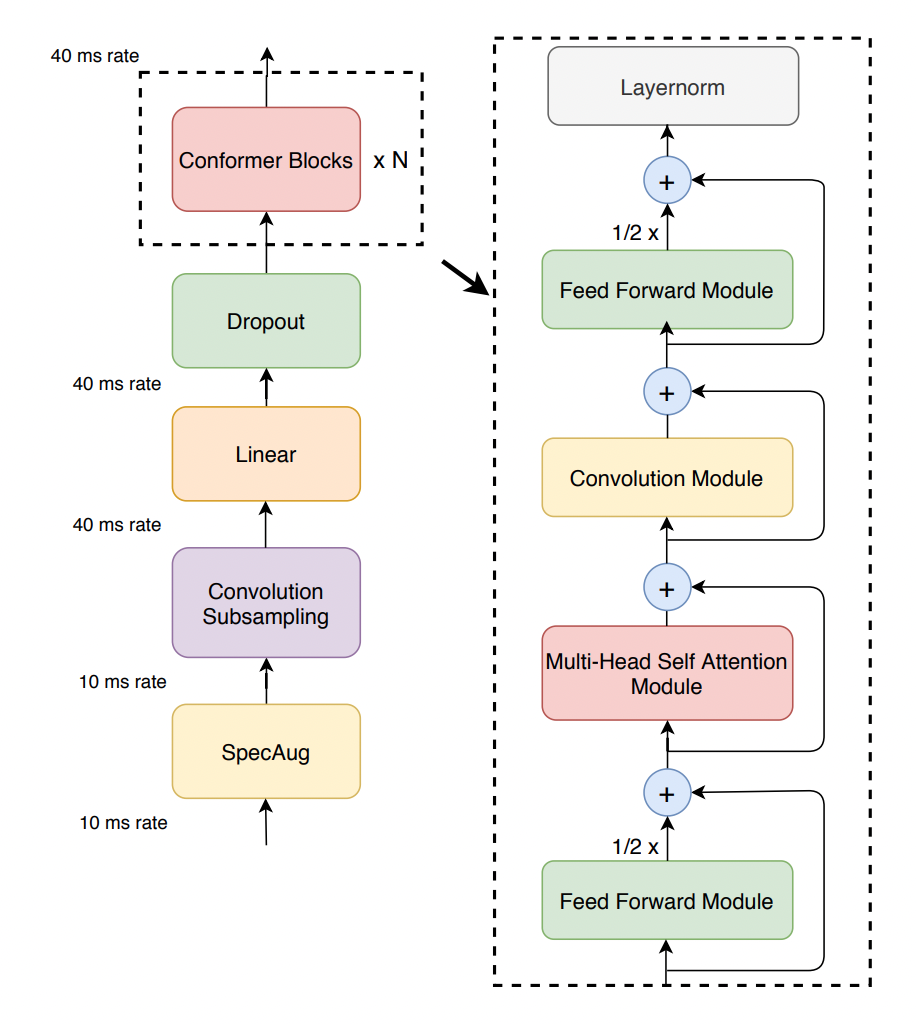

In [20]:
BRANCH = "develop"
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH


  Cloning https://github.com/speechbrain/speechbrain.git (to revision develop) to /tmp/pip-req-build-17xnaxlc
  Running command git clone --filter=blob:none --quiet https://github.com/speechbrain/speechbrain.git /tmp/pip-req-build-17xnaxlc
  Resolved https://github.com/speechbrain/speechbrain.git to commit c75ab5489431fd0a2a7d21160bc37677801cb506
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 31.0 MB/s eta 0:00:00
  Created wheel for speechbrain: filename=speechbrain-1.0.3-py3-none-any.whl size=762391 sha256=e6de8052dc8c13e84dd69a3d8a953c14828a71e44fadf6168592bde359e9f205
  Stored in directory: /tmp/pip-ephem-wheel-cache-6470fxcx/wheels/cc/6d/c4/338bedb17934b628dbf16a28c019cf0143822325c4bdf2afda
Successfully built speechbrain


In [21]:
!wget https://huggingface.co/ddwkim/asr-conformer-transformerlm-ksponspeech/resolve/main/record_0_16k.wav
!wget https://huggingface.co/ddwkim/asr-conformer-transformerlm-ksponspeech/resolve/main/record_1_16k.wav
!wget https://huggingface.co/ddwkim/asr-conformer-transformerlm-ksponspeech/resolve/main/record_2_16k.wav

--2025-06-10 20:37:00--  https://huggingface.co/ddwkim/asr-conformer-transformerlm-ksponspeech/resolve/main/record_0_16k.wav
Resolving huggingface.co (huggingface.co)... 18.239.50.80, 18.239.50.16, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115414 (113K) [audio/wave]
Saving to: ‘record_0_16k.wav’

record_0_16k.wav    100%[===================>] 112.71K  --.-KB/s    in 0.08s   

2025-06-10 20:37:00 (1.35 MB/s) - ‘record_0_16k.wav’ saved [115414/115414]

--2025-06-10 20:37:00--  https://huggingface.co/ddwkim/asr-conformer-transformerlm-ksponspeech/resolve/main/record_1_16k.wav
Resolving huggingface.co (huggingface.co)... 18.239.50.103, 18.239.50.80, 18.239.50.49, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170028 (166K) [audio/wave]
Saving to: ‘record_1_16k.wav’

record_1_16k.wav    100%[=

In [22]:
!pip install speechbrain

In [23]:
from speechbrain.pretrained import EncoderDecoderASR
audio_0 = "./record_0_16k.wav"

# Download and load the pretrained KSponSpeech model
asr_model = EncoderDecoderASR.from_hparams(
    source="ddwkim/asr-conformer-transformerlm-ksponspeech",
    savedir="pretrained_models/asr-conformer-transformerlm-ksponspeech"
)

# Transcribe the audio file
print(asr_model.transcribe_file(audio_0))

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
<ipython-input-23-740214661>:1: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderDecoderASR
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'ddwkim/asr-conformer-transformerlm-ksponspeech' if not cached


hyperparams.yaml:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--ddwkim--asr-conformer-transformerlm-ksponspeech/snapshots/fc7b85d658c210cdd7b960aaee77141b290c2354/hyperparams.yaml' -> '/content/pretrained_models/asr-conformer-transformerlm-ksponspeech/hyperparams.yaml'
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/asr-conformer-transformerlm-ksponspeech.
INFO:s

normalizer.ckpt:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--ddwkim--asr-conformer-transformerlm-ksponspeech/snapshots/fc7b85d658c210cdd7b960aaee77141b290c2354/normalizer.ckpt' -> '/content/pretrained_models/asr-conformer-transformerlm-ksponspeech/normalizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["normalizer"] = /content/pretrained_models/asr-conformer-transformerlm-ksponspeech/normalizer.ckpt
INFO:speechbrain.utils.fetching:Fetch asr.ckpt: Fetching from HuggingFace Hub 'ddwkim/asr-conformer-transformerlm-ksponspeech' if not cached


asr.ckpt:   0%|          | 0.00/183M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--ddwkim--asr-conformer-transformerlm-ksponspeech/snapshots/fc7b85d658c210cdd7b960aaee77141b290c2354/asr.ckpt' -> '/content/pretrained_models/asr-conformer-transformerlm-ksponspeech/asr.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["asr"] = /content/pretrained_models/asr-conformer-transformerlm-ksponspeech/asr.ckpt
INFO:speechbrain.utils.fetching:Fetch lm.ckpt: Fetching from HuggingFace Hub 'ddwkim/asr-conformer-transformerlm-ksponspeech' if not cached


lm.ckpt:   0%|          | 0.00/381M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--ddwkim--asr-conformer-transformerlm-ksponspeech/snapshots/fc7b85d658c210cdd7b960aaee77141b290c2354/lm.ckpt' -> '/content/pretrained_models/asr-conformer-transformerlm-ksponspeech/lm.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["lm"] = /content/pretrained_models/asr-conformer-transformerlm-ksponspeech/lm.ckpt
INFO:speechbrain.utils.fetching:Fetch tokenizer.ckpt: Fetching from HuggingFace Hub 'ddwkim/asr-conformer-transformerlm-ksponspeech' if not cached


tokenizer.ckpt:   0%|          | 0.00/314k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--ddwkim--asr-conformer-transformerlm-ksponspeech/snapshots/fc7b85d658c210cdd7b960aaee77141b290c2354/tokenizer.ckpt' -> '/content/pretrained_models/asr-conformer-transformerlm-ksponspeech/tokenizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["tokenizer"] = /content/pretrained_models/asr-conformer-transformerlm-ksponspeech/tokenizer.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: normalizer, asr, lm, tokenizer
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): normalizer -> /content/pretrained_models/asr-conformer-transformerlm-ksponspeech/normalizer.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): asr -> /content/pretrained_models/asr-conformer-transformerlm-ksponspeech/asr.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from 

오늘 왜 전화했어


In [24]:
import speechbrain as sb

# Create the CER metric object
cer_metric = sb.utils.metric_stats.ErrorRateStats()

# Reference (target) and hypothesis (prediction), with spaces removed
ref = "".join("Today, why did you call".split())
hyp = "".join(asr_model.transcribe_file(audio_0).split())

# Append using positional arguments only
cer_metric.append("utt1", hyp, ref)

# Summarize and print CER
cer = cer_metric.summarize("error_rate")
print(f"CER: {cer:.4f}")

CER: 100.0000


In [25]:
import torch
import torchaudio
from torch.nn.utils.rnn import pad_sequence

In [26]:
audio_files=[]
audio_files.append("./record_0_16k.wav")
audio_files.append("./record_1_16k.wav")
audio_files.append("./record_2_16k.wav")
sigs=[]
lens=[]
for audio_file in audio_files:
  snt, fs = torchaudio.load(audio_file)
  sigs.append(snt.squeeze())
  lens.append(snt.shape[1])
batch = pad_sequence(sigs, batch_first=True, padding_value=0.0)
lens = torch.Tensor(lens) / batch.shape[1]
hyps = asr_model.transcribe_batch(batch, lens)[0]
print(hyps)

['오늘 왜 전화했어', '한국어 음성 인식 시흥용 문장입니다', '여보세요 네 안녕하세요']


In [27]:
import speechbrain as sb
refs = ["Why did you call today?", "This is a test sentence for Korean speech recognition.","Hello, yes, hi."]
cer_metric = sb.utils.metric_stats.ErrorRateStats()
refs_chars = ["".join(ref.split()) for ref in refs]
hyps_chars = ["".join(hyp.split()) for hyp in hyps]
cer_metric = sb.utils.metric_stats.ErrorRateStats()
cer_metric.append(audio_files, hyps_chars, refs_chars)
cer_metric.summarize("error_rate")

100.0

# Wav2Vec2, 2020

Facebook AI가 개발한 Self-Supervised 학습 기반 모델로, 대규모 비지도 음성 데이터를 효과적으로 학습

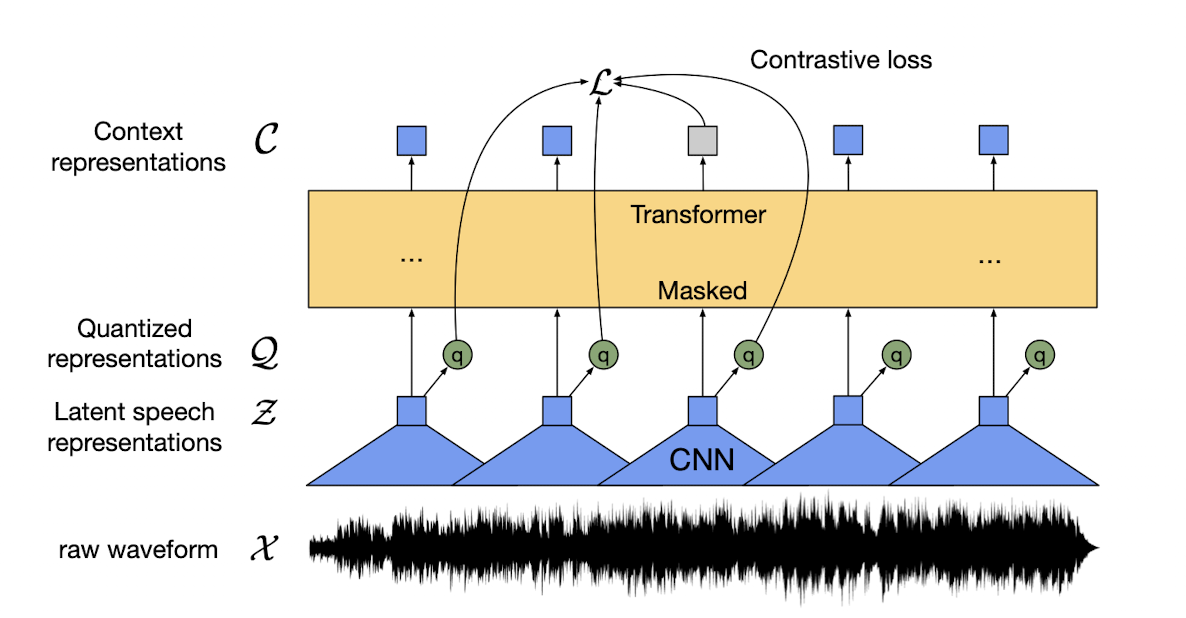

In [28]:
!pip install transformers

In [29]:
import torch
import librosa
import numpy as np
import soundfile as sf
from scipy.io import wavfile
from IPython.display import Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [30]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
!wget https://huggingface.co/datasets/UniDataPro/british-english-speech-recognition-dataset/resolve/main/audio/1.wav

--2025-06-10 20:42:33--  https://huggingface.co/datasets/UniDataPro/british-english-speech-recognition-dataset/resolve/main/audio/1.wav
Resolving huggingface.co (huggingface.co)... 18.239.50.80, 18.239.50.49, 18.239.50.16, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.80|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/e4/98/e498a9ce2262e6e889d124d84b267c9617ee6186111b82136b7a4faf6fe2d140/242d8b1d6a9b1dfa4639c22676eb8ce4c0011ca49d6adf1cce26eff9c4575a1f?response-content-disposition=inline%3B+filename*%3DUTF-8%27%271.wav%3B+filename%3D%221.wav%22%3B&response-content-type=audio%2Fwave&Expires=1749591753&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0OTU5MTc1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2U0Lzk4L2U0OThhOWNlMjI2MmU2ZTg4OWQxMjRkODRiMjY3Yzk2MTdlZTYxODYxMTFiODIxMzZiN2E0ZmFmNmZlMmQxNDAvMjQyZDhiMWQ2YTliMWRmYTQ2MzljMjI2NzZlYjhjZTRjMDAxMWNhNDlk

In [32]:
file_name = '/content/1.wav'
Audio(file_name)

In [33]:
data = wavfile.read(file_name)
framerate = data[0]
sounddata = data[1]
time = np.arange(0,len(sounddata))/framerate
print('Sampling rate:',framerate,'Hz')

Sampling rate: 16000 Hz


In [34]:
input_audio, _ = librosa.load(file_name, sr=16000)

In [35]:
input_values = tokenizer(input_audio, return_tensors="pt").input_values
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)[0]
print(transcription)

WHEN YOU HAVE THE TIME DOIT BECASIS YOU KNOW IS


# Whisper, 2022

OpenAI가 개발한 다국어 음성 인식 모델로, 다양한 언어와 소음을 처리하는 데 강점

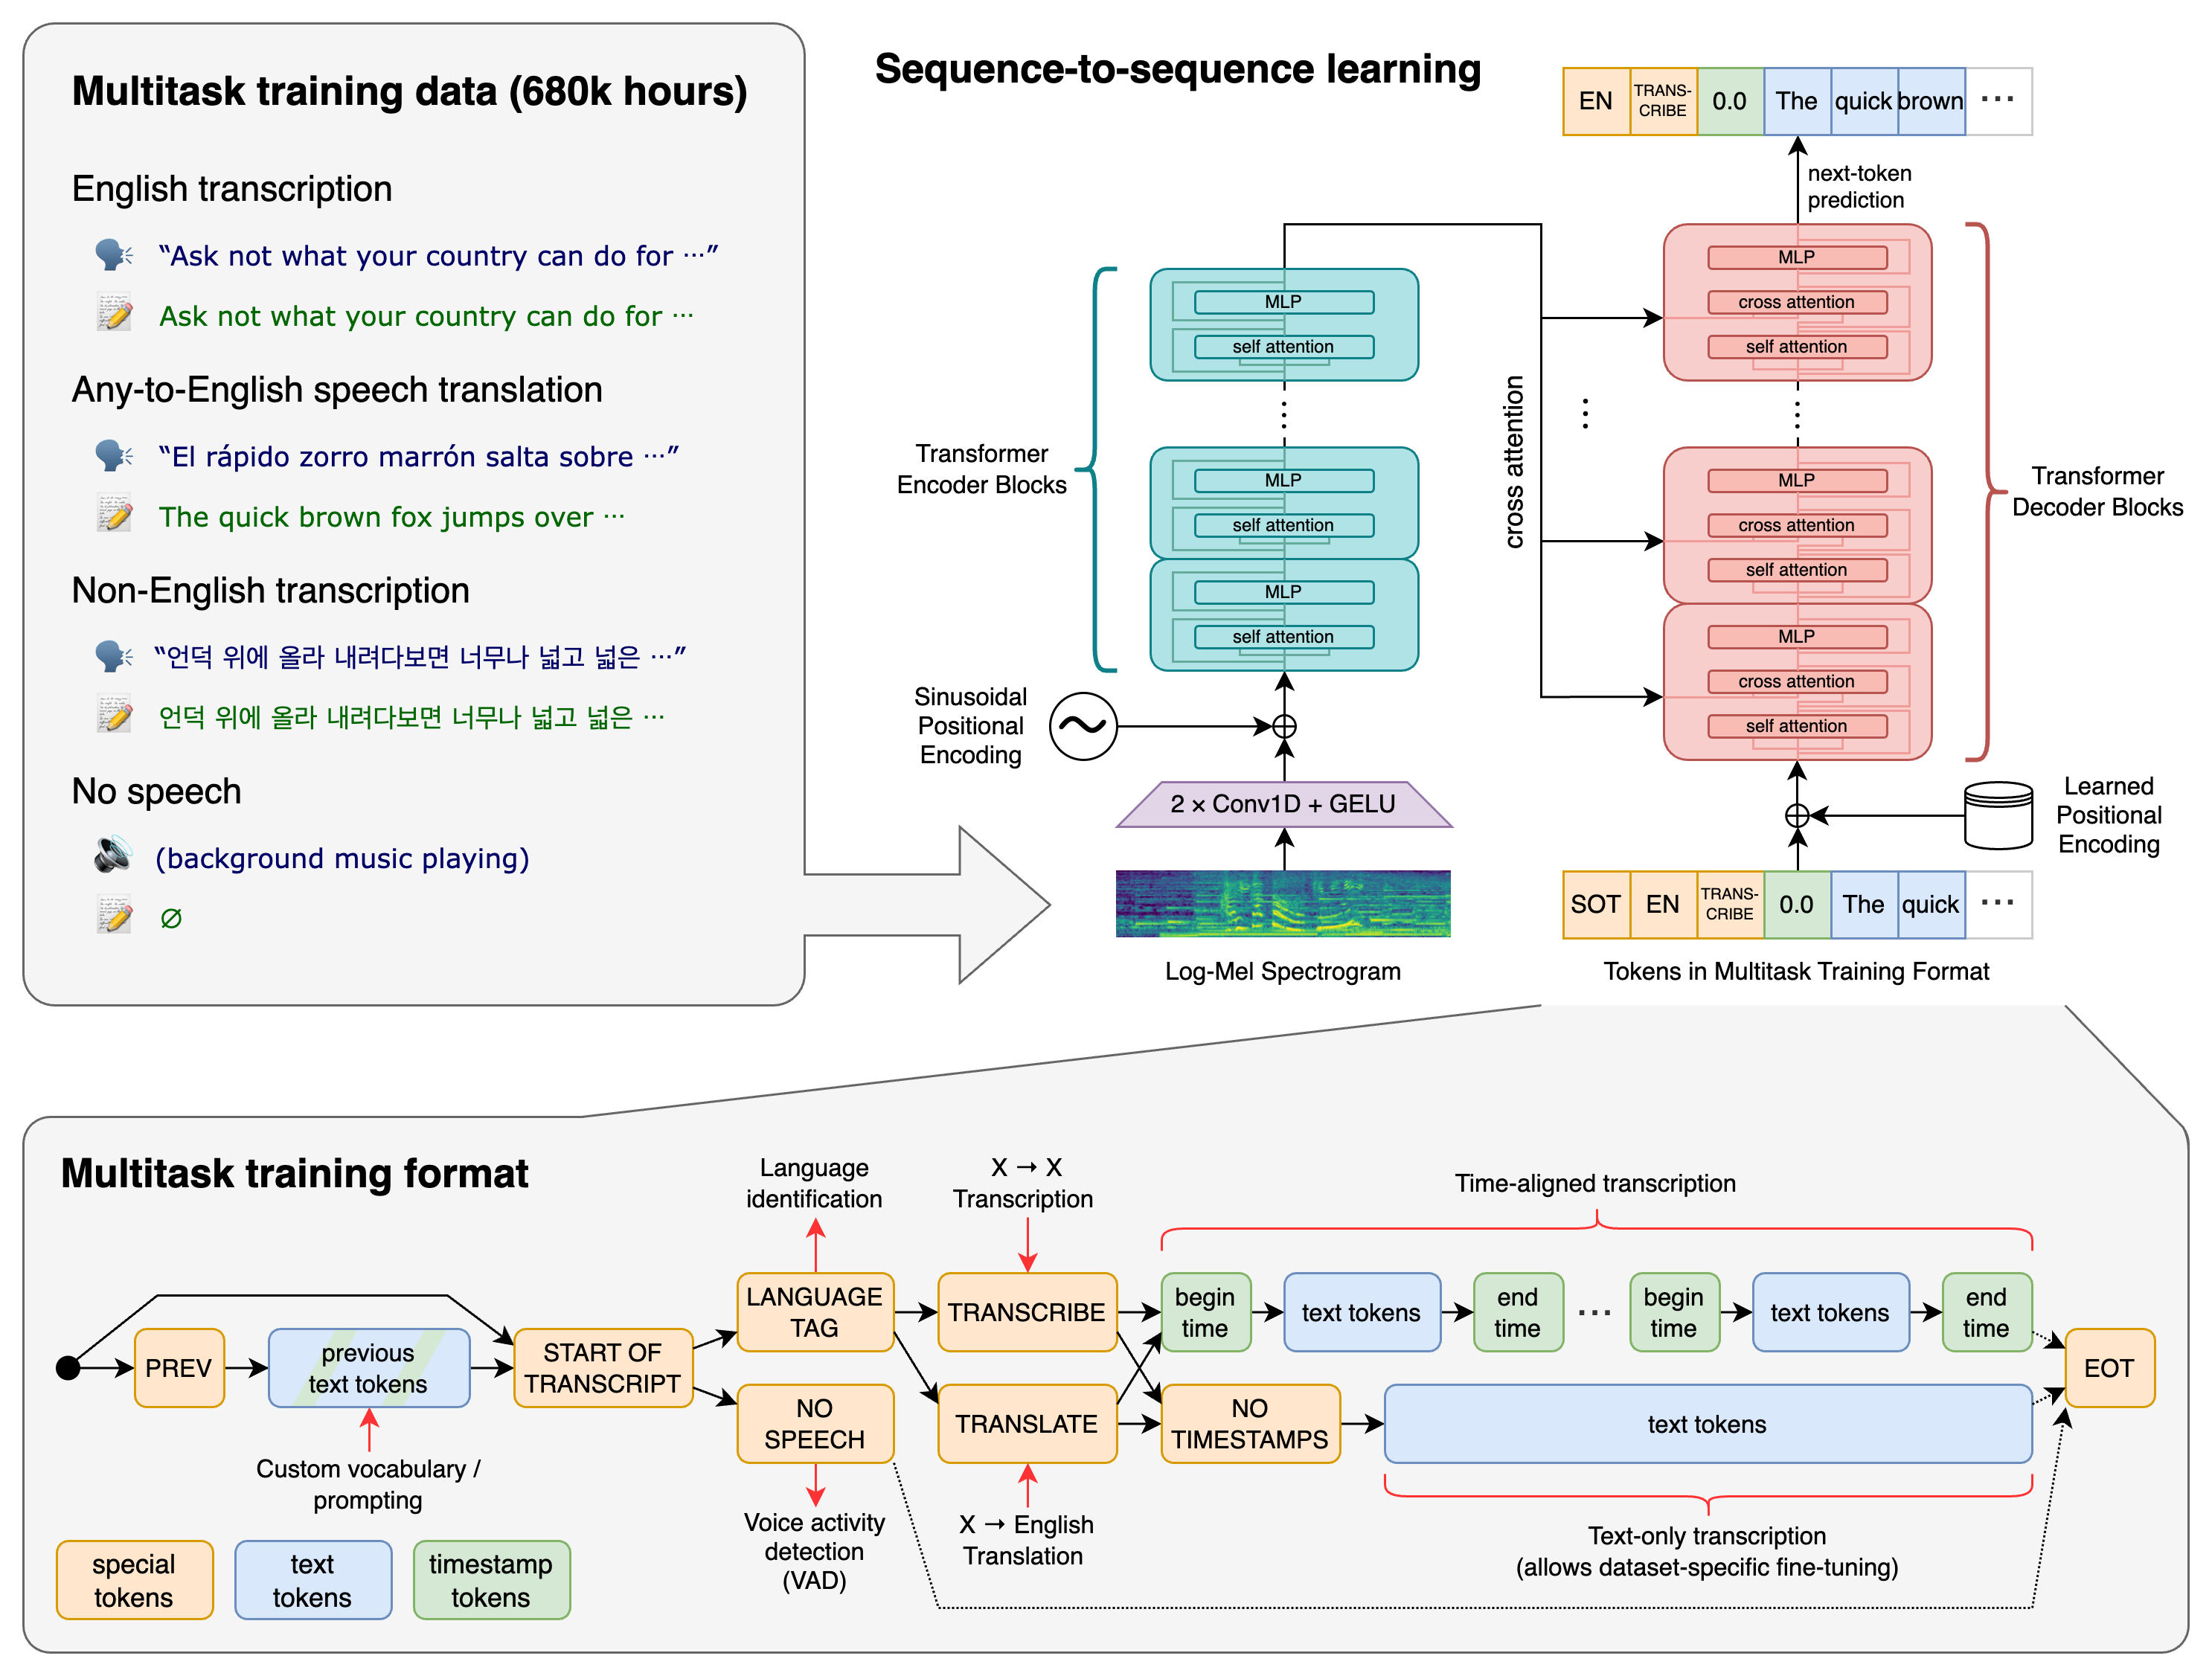

Whisper 모델을 사용하고 트랜스크립션 결과를 평가하는 데 필요한 Python 패키지 설치

In [36]:
! pip install git+https://github.com/openai/whisper.git
! pip install jiwer

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-_ytka_74
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-_ytka_74
  Resolved https://github.com/openai/whisper.git to commit dd985ac4b90cafeef8712f2998d62c59c3e62d22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803707 sha256=65c780d3349948d99d7ea4556e4fc992584162321bd119abfbccc923cd3089ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-dt10s6kt/wheels/1f/1d/98/9583695e6695a6ac0ad42d87511097dce5ba486647dbfecb0e
Successfully built openai-whisper
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.4 MB/s eta 0:00:00


LibriSpeech 데이터셋 로드: torchaudio를 사용하여 LibriSpeech 코퍼스의 테스트-클린 분할 로드

In [37]:
import os
import numpy as np
try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass
import torch
import pandas as pd
import whisper
import torchaudio
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
import torch
import torchaudio
import os
import whisper

class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple wrapper for the LibriSpeech dataset that:
    - Pads or trims audio to 30 seconds
    - Returns (log-mel spectrogram, text) pairs
    """
    def __init__(self, split="test-clean", device="cpu"):
        """
        Args:
            split (str): Dataset split to load (e.g., "train-clean-100", "test-clean", etc.)
            device (str): The device to move the audio tensor to (e.g., "cuda" or "cpu")
        """
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Returns:
            mel (Tensor): Log-mel spectrogram of the audio (trimmed/padded to 30s)
            text (str): Corresponding transcription
        """
        audio, sample_rate, text, _, _, _ = self.dataset[index]

        # Ensure audio is sampled at 16 kHz as required by Whisper
        assert sample_rate == 16000, "Sample rate must be 16 kHz"

        # Pad or trim audio to exactly 30 seconds (Whisper default)
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)

        # Convert waveform to log-Mel spectrogram
        mel = whisper.log_mel_spectrogram(audio)

        return mel, text

In [39]:
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

100%|██████████| 331M/331M [00:04<00:00, 76.3MB/s]


기본 Whisper 모델을 사용한 추론: 데이터 세트의 모든 발화를 전사하는 데 몇 분 정도 걸림

In [40]:
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 88.8MiB/s]


Model is English-only and has 71,825,408 parameters.


In [41]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True)

In [44]:
hypotheses = []
references = []

for mels, texts in tqdm(loader):
    mels = mels.to(model.device)  # Move spectrograms to the model's device

    results = model.decode(mels, options)

    hypotheses.extend([result.text for result in results])
    references.extend(texts)

  0%|          | 0/164 [00:00<?, ?it/s]

In [45]:
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...


No charts were generated by quickchart


Word Error Rate (WER) 계산: 단어 오류율 계산하기 이제 영어 정규화 구현을 사용하여 표준화하고 WER을 계산

In [46]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()

In [47]:
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuffered into you his belly counseled him,stuff it into you his belly counseled him
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hello bertie any good in your mind,hello bertie any good in your mind
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
...,...,...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


No charts were generated by quickchart


In [50]:
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))
print(f"WER: {wer * 100:.2f} %")

WER: 4.28 %
